In [8]:
import os
import pandas as pd

# Path to the data directory
data_dir = './data'

# List all folders (people) in the data directory
people_folders = os.listdir(data_dir)

# Initialize an empty list to hold the data
data = []

# Loop through each folder (person)
for label, person_folder in enumerate(people_folders):
    # Path to the current person's folder
    person_folder_path = os.path.join(data_dir, person_folder)
    
    # Ensure it's a directory
    if os.path.isdir(person_folder_path):
        # List all audio files in the current person's folder
        audio_files = os.listdir(person_folder_path)
        
        # Loop through each audio file and create a record with the label (person) and filename
        for audio_file in audio_files:
            # Create the file path
            file_path = os.path.join(person_folder_path, audio_file)
            # Append the filename and label to the data list
            data.append([file_path, label])

# Convert the list to a DataFrame
df = pd.DataFrame(data, columns=['file_path', 'label'])

# Show the first few records
print(df.head())


              file_path  label
0   ./data\1\0_01_0.wav      0
1   ./data\1\0_01_1.wav      0
2  ./data\1\0_01_10.wav      0
3  ./data\1\0_01_11.wav      0
4  ./data\1\0_01_12.wav      0


In [50]:
import os
import pandas as pd
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

# Step 1: Read data and prepare labels and file paths
def get_subfolder_names(main_folder_path):
    file_names = []
    subfolder_names = []
    for folder_ID in os.listdir(main_folder_path):
        subfolder_path = os.path.join(main_folder_path, folder_ID)
        for file_ID in os.listdir(subfolder_path):
            if os.path.isdir(subfolder_path):
                subfolder_names.append(folder_ID)
            if os.path.isfile(os.path.join(subfolder_path, file_ID)):
                file_names.append(file_ID)
    return subfolder_names, file_names

# Load all subfolder and file names into a DataFrame
main_folder_path = "C:/Users/ryan_/OneDrive/Documents/USF/Courses/Fall 2024/Mobile Biometrics/Project/Voice Recognition/data"
subfolders, file_names = get_subfolder_names(main_folder_path)
data = {'Label': subfolders, 'File Name': file_names}
df = pd.DataFrame(data)

# Step 2: Generate spectrograms and split the dataset
def add_noise_to_audio(audio, noise_factor):
    """
    Adds Gaussian noise to the audio signal.
    
    Parameters:
    - audio: The raw audio signal (numpy array)
    - noise_factor: Standard deviation of the Gaussian noise to be added
    
    Returns:
    - Noisy audio signal (numpy array)
    """
    noise = np.random.normal(0, noise_factor, audio.shape)
    noisy_audio = audio + noise
    # Clip the noisy audio to prevent values from going out of the valid range [-1, 1]
    noisy_audio = np.clip(noisy_audio, -1, 1)
    return noisy_audio


class VoiceDataset(Dataset):
    def __init__(self, df, main_folder_path, transform=None, noise_factor=0.0001):
        self.df = df
        self.main_folder_path = main_folder_path
        self.transform = transform
        self.noise_factor = noise_factor  # Parameter to control the amount of noise

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = row['Label']
        file = row['File Name']

        filepath = os.path.join(self.main_folder_path, label, file)

        label = int(label)-1
        y, sr = librosa.load(filepath, sr=None)

        # Ensure the audio is at least 1 second long
        target_length = sr * 1  # 1 second of audio
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        else:
            y = y[:target_length]

        # Add noise to the audio signal
        noisy_audio = add_noise_to_audio(y, self.noise_factor)

        # Perform Short-Time Fourier Transform (STFT)
        D = librosa.stft(noisy_audio)  # Use noisy audio here
        DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        # Convert the spectrogram to a tensor and normalize if needed
        spectrogram = torch.tensor(DB, dtype=torch.float32)

        # Normalize the spectrogram (ResNet18 normalization)
        spectrogram = (spectrogram - spectrogram.mean()) / spectrogram.std()
        spectrogram = torch.nn.functional.interpolate(spectrogram.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)


        # If a transform is provided (e.g., resizing or additional augmentations)
        #if self.transform:
         #   spectrogram = self.transform(spectrogram)

        #    print('spectrogram shape is', spectrogram.shape)

        return spectrogram, label

# Step 3: Split data by person and create train, validation, test sets
# Create a mapping of subfolders (people) to file paths
# Step 3: Split data by person and create train, validation, test sets
# Create a mapping of subfolders (people) to file paths
people_data = {}
for _, row in df.iterrows():
    label = row['Label']
    file = row['File Name']
    filepath = os.path.join(main_folder_path, label, file)
    
    if label not in people_data:
        people_data[label] = []
    people_data[label].append(filepath)


# Use all the available 40 people (folders)
# Since labels are already the folder names, we do not need a separate mapping
labels = list(people_data.keys())

# Split files for each person into train, val, and test sets

train_files, val_test_files = [], []
train_label, val_test_label = [], []

for person in labels:
    person_files = []
    person_fil = people_data[person]
    for i in range(500):
       if i % 4 == 0:
           person_files.append(person_fil[i])

    train_size = int(0.8 * len(person_files))
    
    # Split data for each person
    train_files.extend(person_files[:train_size])
    train_label.extend([person]*(train_size))  # Use folder name (string) as label
    val_test_files.extend(person_files[train_size:])
    val_test_label.extend([person]*(len(person_files) - train_size))  # Use folder name (string) as label
    
# Further split the remaining 10% into val and test sets
val_files, test_files, val_label, test_label = train_test_split(val_test_files, val_test_label, test_size=0.5)

# Combine the files into DataFrames using the label directly
train_df = pd.DataFrame({'File Name': train_files, 'Label': train_label})
val_df = pd.DataFrame({'File Name': val_files, 'Label': val_label})
test_df = pd.DataFrame({'File Name': test_files, 'Label': test_label})



# Step 4: Create DataLoaders for training, validation, and test sets
# Define a transform for ResNet18 preprocessing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

train_dataset = VoiceDataset(train_df, main_folder_path, transform=transform)
val_dataset = VoiceDataset(val_df, main_folder_path, transform=transform)
test_dataset = VoiceDataset(test_df, main_folder_path, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# The datasets and dataloaders are now ready to be used with a model for training


In [51]:
len(person_fil)

500

In [52]:
for images , labels in train_loader:
    print(images.shape)
    print(labels.shape)
    print(type(labels[0]))
    break

torch.Size([64, 224, 224])
torch.Size([64])
<class 'torch.Tensor'>


In [53]:
len(train_loader)

63

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def add_noise_to_spectrogram(spectrogram, noise_factor):
    """
    Adds Gaussian noise to a spectrogram.
    
    Parameters:
    - spectrogram: The input spectrogram (numpy array)
    - noise_factor: Standard deviation of the Gaussian noise to be added
    
    Returns:
    - Noisy spectrogram (numpy array)
    """
    noise = np.random.normal(0, noise_factor, spectrogram.shape)
    noisy_spectrogram = spectrogram + noise
    # Clip the noisy spectrogram values to a valid range (0 to max value)
    noisy_spectrogram = np.clip(noisy_spectrogram, 0, 1)  # Ensure values are within [0, 1] range
    return noisy_spectrogram


def plot_spectrograms(dataloader, title, n_images=16, noise_factor=0.001):
    # Set up the plot
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # 4x4 grid of subplots
    axes = axes.flatten()  # Flatten the axes for easy iteration

    # Iterate through the dataloader and plot 16 images
    for i, (spectrograms, labels) in enumerate(dataloader):
        if i >= 1:  # We only need the first batch
            break

        # Randomly select 16 spectrograms from the batch
        random_indices = np.random.choice(len(spectrograms), size=n_images, replace=False)

        for j, idx in enumerate(random_indices):
            ax = axes[j]
            spec = spectrograms[idx].numpy()

            # Normalize the spectrogram to the range [0, 1] for better display
            norm_spec = (spec - np.min(spec)) / (np.max(spec) - np.min(spec) + 1e-8)

            # Add noise to the spectrogram
            noisy_spec = add_noise_to_spectrogram(norm_spec, noise_factor)

            # Apply log scaling (logarithmic transformation) for better visualization
            log_spec = np.log(noisy_spec + 1e-8)  # Adding a small epsilon to avoid log(0)

            # Plot the spectrogram
            ax.imshow(spec, aspect='auto', cmap='inferno', origin='lower')
            ax.set_title(f'Label: {labels[idx]}')
            ax.axis('off')  # Hide axis ticks and labels

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Step 1: Plot 16 images for one person in the training set with noise
plot_spectrograms(train_loader, "Training Set: 16 Spectrograms with Noise")

# Step 2: Plot 16 images for one person in the validation set with noise
plot_spectrograms(val_loader, "Validation Set: 16 Spectrograms with Noise")

# Step 3: Plot 16 images for one person in the test set with noise
plot_spectrograms(test_loader, "Test Set: 16 Spectrograms with Noise")


In [47]:
import torch
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cpu')

# MOdel

In [54]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1 channel instead of 3 (for grayscale images)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modify the final fully connected layer to match the number of labels (for CelebA, you have N unique labels)
num_labels = 40  # This is the number of unique labels after filtering
model.fc = nn.Linear(model.fc.in_features, num_labels)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last fully connected layer to allow it to be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss function
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)  # Only optimize the last layer

# Number of epochs for training
num_epochs = 10

# Training and validation loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Train loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            images, labels = images.to(device), labels.to(device)

            # Reshape images to have 1 channel (grayscale)
            images = images.unsqueeze(1)  # Now the shape is [batch_size, 1, 224, 224]

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Calculate training accuracy
        train_accuracy = correct_train / total_train

        # Validation loop
        model.eval()
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                images = images.unsqueeze(1)  # Now the shape is [batch_size, 1, 224, 224]
                
                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                correct_valid += (predicted == labels).sum().item()
                total_valid += labels.size(0)

        # Calculate validation accuracy
        valid_accuracy = correct_valid / total_valid

        # Print loss and accuracy for each epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

        # Save the model if validation accuracy is better
        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            torch.save(model.state_dict(), "best_resnet18.pth")


In [56]:
# Call the training function with the training and validation dataloaders
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50 (Train):   0%|          | 0/63 [00:02<?, ?it/s]


KeyboardInterrupt: 

C:\Users\ryan_\AppData\Local\Temp\ipykernel_29200\1426886700.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet18.pth"))


Test Accuracy: 0.2600
Confusion Matrix:
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ... 11  0  0]
 [ 0  0  0 ...  0  3  0]
 [ 1  0  0 ...  0  0  1]]


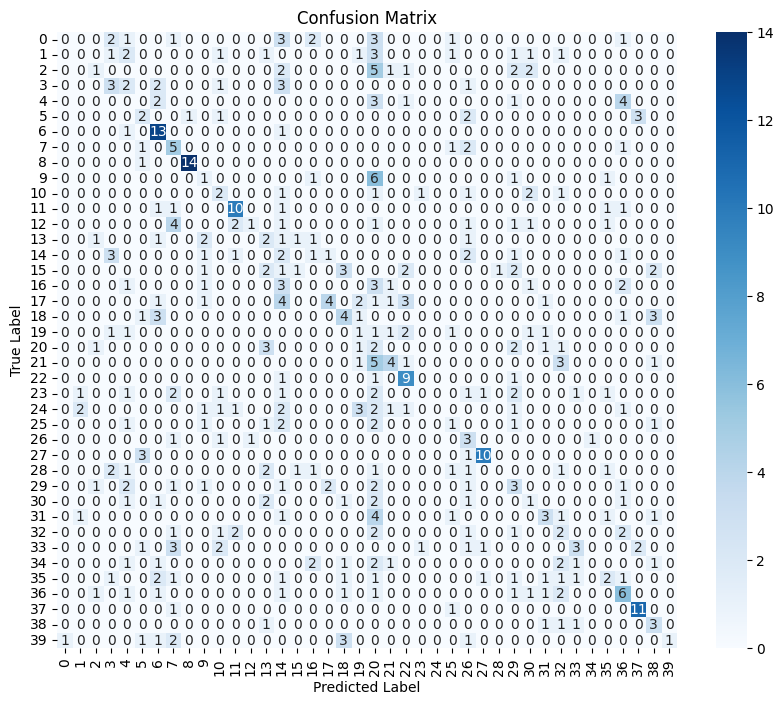

In [59]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    # Load the best model weights if saved
    model.load_state_dict(torch.load("best_resnet18.pth"))
    model.eval()

    all_preds = []
    all_labels = []

    # No gradient computation during evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.unsqueeze(1)
            outputs = model(images)

            # Get the predictions
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_labels), yticklabels=range(num_labels))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call the function with your test dataloader
evaluate_model(model, test_loader)


In [60]:

for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.unsqueeze(1)
            outputs = model(images)
            #outputs = torch.softmax(outputs, dim=1)



for i in range(len(torch.max(outputs, 1)[1])):
    formatted_tensor = [f"{val:.2f}" for val in outputs[i].tolist()]
    print('True:',labels[i], '-- predicted:', torch.max(outputs, 1)[1][i], formatted_tensor)

True: tensor(27) -- predicted: tensor(5) ['-0.03', '-2.16', '-2.06', '-0.56', '-1.30', '2.90', '1.02', '1.11', '1.25', '-1.91', '-0.36', '0.96', '1.17', '-0.91', '-0.72', '-1.30', '-0.75', '-2.17', '1.80', '0.23', '-1.27', '-0.94', '-2.71', '0.14', '0.61', '-1.05', '2.57', '2.15', '-0.77', '-1.69', '-0.42', '-0.87', '0.01', '1.40', '0.22', '0.99', '-0.55', '2.51', '1.21', '1.21']
True: tensor(16) -- predicted: tensor(30) ['-0.32', '-0.31', '-0.05', '-1.54', '1.00', '-1.22', '0.33', '-0.40', '-2.47', '0.58', '0.29', '-0.41', '0.01', '-0.38', '0.68', '1.13', '1.18', '0.30', '0.83', '0.52', '1.61', '-0.16', '-0.55', '-0.06', '0.13', '-0.24', '-0.50', '-2.62', '0.72', '1.07', '1.94', '1.30', '0.71', '-1.71', '-0.24', '-0.71', '1.46', '-2.08', '0.56', '-1.92']
True: tensor(37) -- predicted: tensor(37) ['-0.41', '-1.28', '-2.98', '-1.60', '-1.40', '2.88', '-1.59', '1.95', '1.76', '-2.04', '1.17', '-0.97', '1.61', '-2.03', '0.32', '-2.39', '-0.02', '-2.61', '2.06', '1.01', '-1.66', '-0.82', '

In [61]:
import torch
import pandas as pd

# Placeholder for data to save
data_to_save = []

# Loop through your data loader
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    images = images.unsqueeze(1)
    outputs = model(images)

    outputs = torch.softmax(outputs, dim=1) # apply sofmax
    
    for i in range(len(outputs)):
        # Extract relevant information
        true_label = labels[i].item()
        predicted_label = torch.argmax(outputs[i]).item()
        formatted_tensor = [f"{val:.4f}" for val in outputs[i].tolist()]
        
        # Add to data list as a single row
        row = [true_label, predicted_label] + formatted_tensor
        data_to_save.append(row)
    

# Define column names
num_elements = len(formatted_tensor)  # Number of elements in the tensor
columns = ["True Label", "Predicted Label"] + [f"{i}" for i in range(num_elements)]

# Create a DataFrame and save it to a CSV file
df = pd.DataFrame(data_to_save, columns=columns)
df.to_csv("results.csv", index=False)

print("Data saved to 'results.csv'.")


Data saved to 'results.csv'.
